In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [18]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [19]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 16
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [21]:
def createANNmodel():
    ANN = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.005)

    return ANN, lossfun, optimizer

In [22]:
tmpmodel = createANNmodel()[0]
print(tmpmodel)

for i in tmpmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [25]:
numEpochs = 1000

def trainTheModel(L1lambda):
    trainAcc = []
    testAcc = []
    losses = []

    nweights = 0
    for pname, weight in ANN.named_parameters():
        if 'bias' not in pname:
            nweights = nweights + weight.numel()

    for epochi in range(numEpochs):
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            yHat = ANN(X)

            loss = lossfun(yHat, y)

            L1_term = torch.tensor(0., requires_grad=True)
            for pname,weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            loss = loss + L1lambda*L1_term/nweights

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
            batchLoss.append( loss.item() )

        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        X,y = next(iter(test_loader))
        predlabels = torch.argmax( ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    return trainAcc,testAcc,losses

In [26]:
ANN,lossfun,optimizer = createANNmodel()

L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

In [28]:
def smooth(x,k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

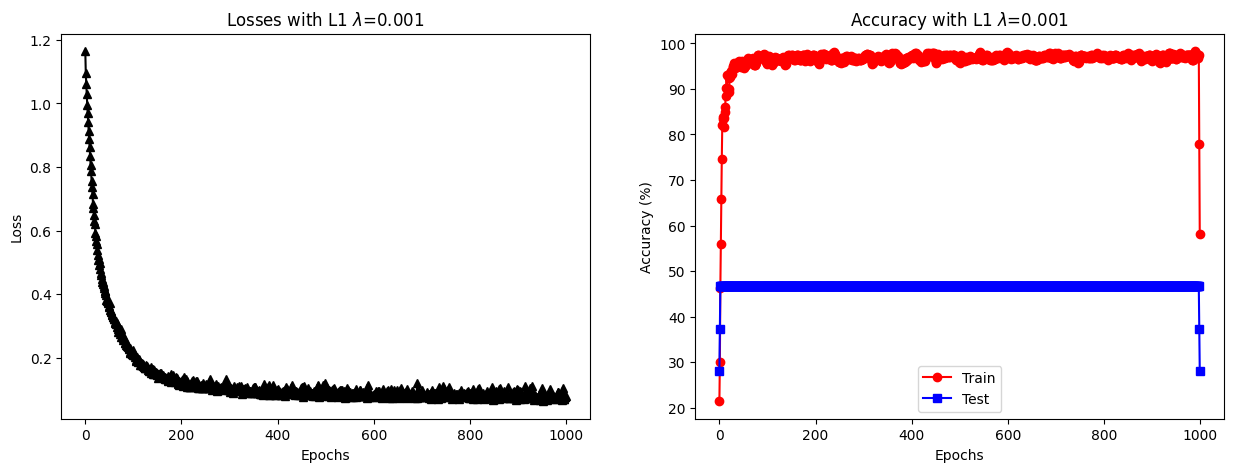

In [29]:
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(smooth(trainAcc),'ro-')
ax[1].plot(smooth(testAcc),'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [30]:
L1lambda = np.linspace(0,.005,10)

accuracyResultsTrain = np.zeros((numEpochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numEpochs,len(L1lambda)))

for li in range(len(L1lambda)):

    ANNiris,lossfun,optimizer = createANNmodel()
    trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li]  = smooth(testAcc,10)

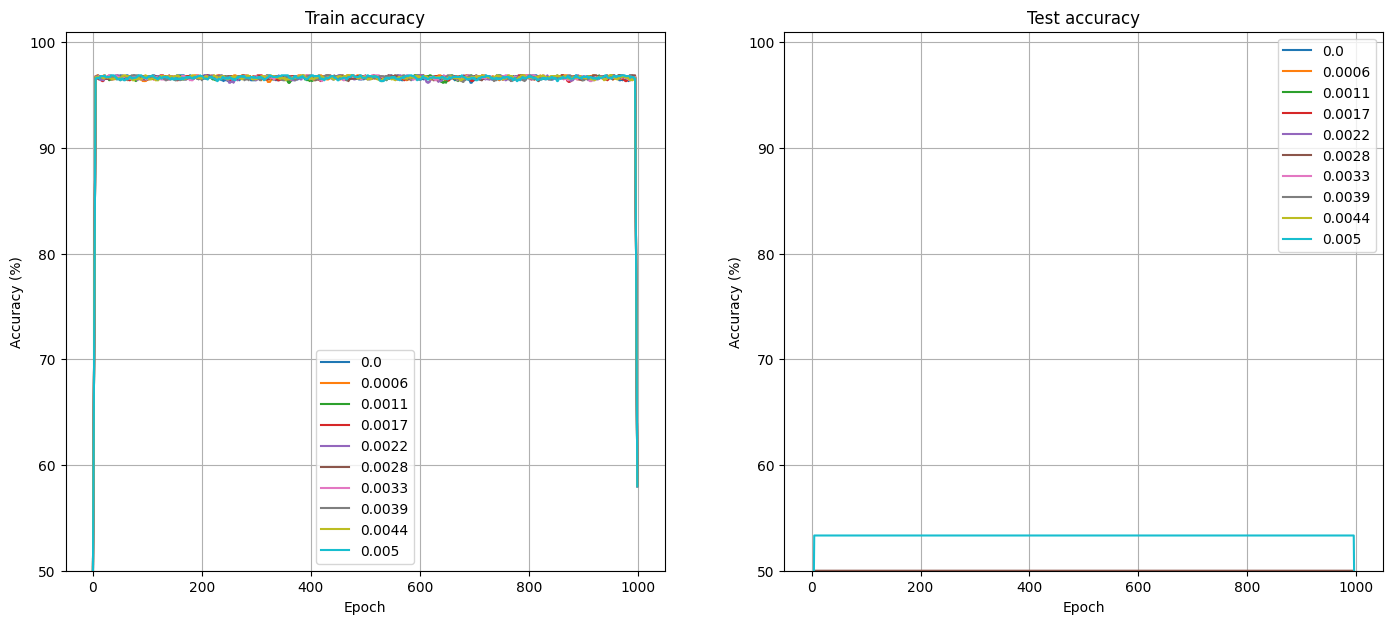

In [31]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i,4) for i in L1lambda]

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

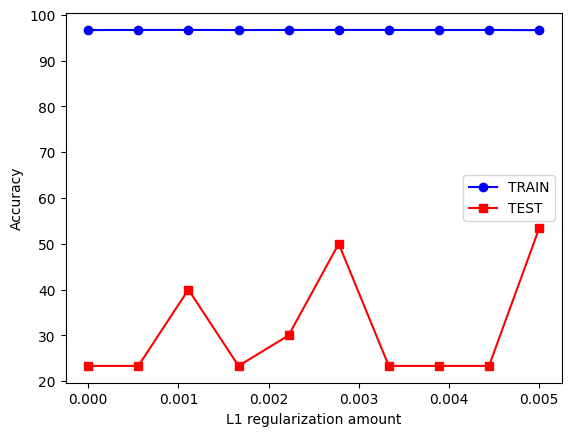

In [32]:
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()